100%|██████████| 2948/2948 [00:05<00:00, 561.09it/s]


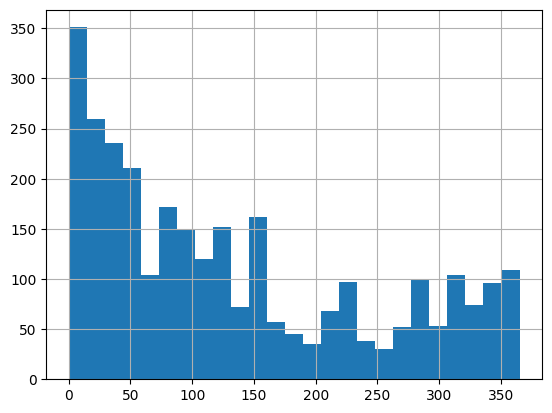

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillTripleImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save
from mandrill.losses import ExponentialDecayLoss

learning_rate = 1e-4
batch_size = 32
num_epochs = 50
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, lin_start=1024, n_lin=0)

# Loss function
criterion = ExponentialDecayLoss() # nn.MSELoss()
val_criterion = ExponentialDecayLoss() # nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)

name="exp1_regression_exp_loss"
model = load(model, "vgg_face", exp_name=name)


# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = val_criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val L1: {val_loss:.4f}")

Using device: cuda


100%|██████████| 19/19 [00:03<00:00,  4.92it/s]


Epoch [1/50] - Train Loss: 0.0011 - Val L1: 0.0026


100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


Epoch [2/50] - Train Loss: 0.0010 - Val L1: 0.0023


100%|██████████| 19/19 [00:04<00:00,  4.56it/s]


Epoch [3/50] - Train Loss: 0.0008 - Val L1: 0.0023


100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


Epoch [4/50] - Train Loss: 0.0008 - Val L1: 0.0022


100%|██████████| 19/19 [00:04<00:00,  4.26it/s]


Epoch [5/50] - Train Loss: 0.0006 - Val L1: 0.0027


100%|██████████| 19/19 [00:04<00:00,  4.39it/s]


Epoch [7/50] - Train Loss: 0.0005 - Val L1: 0.0021


100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


Epoch [8/50] - Train Loss: 0.0005 - Val L1: 0.0021


100%|██████████| 19/19 [00:04<00:00,  4.54it/s]


Epoch [9/50] - Train Loss: 0.0005 - Val L1: 0.0021


100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


Epoch [10/50] - Train Loss: 0.0004 - Val L1: 0.0021


100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


Epoch [11/50] - Train Loss: 0.0003 - Val L1: 0.0023


100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


Epoch [12/50] - Train Loss: 0.0003 - Val L1: 0.0021


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [13/50] - Train Loss: 0.0003 - Val L1: 0.0021


100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


Epoch [14/50] - Train Loss: 0.0003 - Val L1: 0.0020


100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


Epoch [15/50] - Train Loss: 0.0003 - Val L1: 0.0022


100%|██████████| 19/19 [00:03<00:00,  4.94it/s]


Epoch [16/50] - Train Loss: 0.0003 - Val L1: 0.0021


100%|██████████| 19/19 [00:03<00:00,  4.94it/s]


Epoch [17/50] - Train Loss: 0.0003 - Val L1: 0.0022


100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


Epoch [18/50] - Train Loss: 0.0003 - Val L1: 0.0021


 42%|████▏     | 31/74 [00:25<00:35,  1.22it/s]


KeyboardInterrupt: 

Predicted Values: 46.52208521962166
Actual Values: 49.99999962747097
Prediction Error:  -3.477914407849312



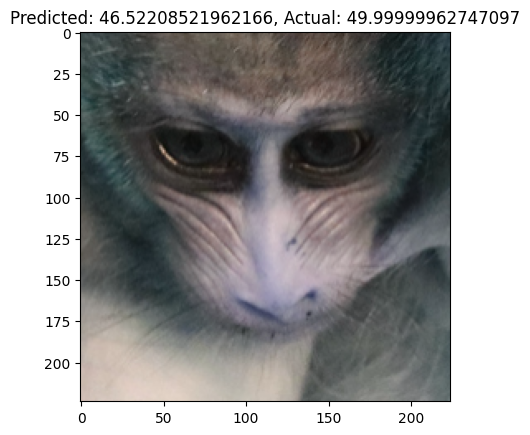

Predicted Values: 314.9907922744751
Actual Values: 344.99998927116394
Prediction Error:  -30.009196996688843



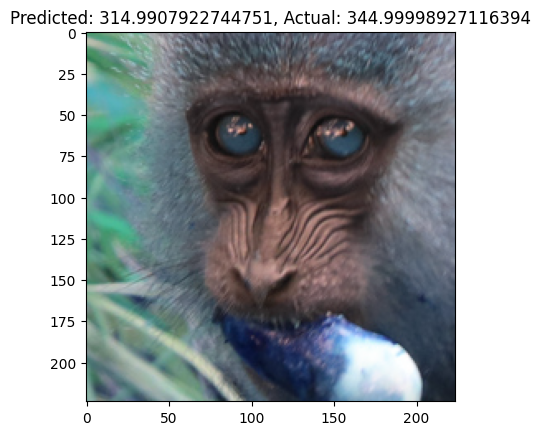

Predicted Values: 186.25044256448746
Actual Values: 164.00000095367432
Prediction Error:  22.25044161081314



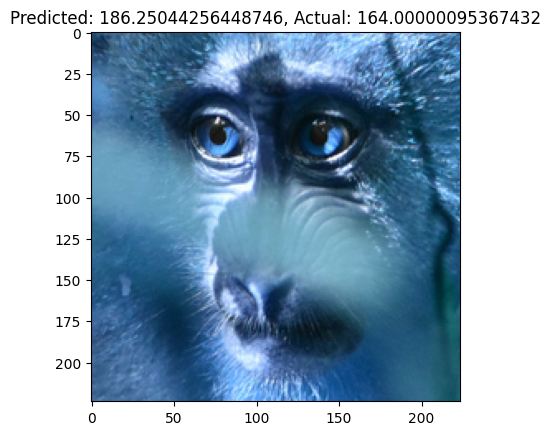

Predicted Values: 21.12475298345089
Actual Values: 39.999999701976776
Prediction Error:  -18.875246718525887



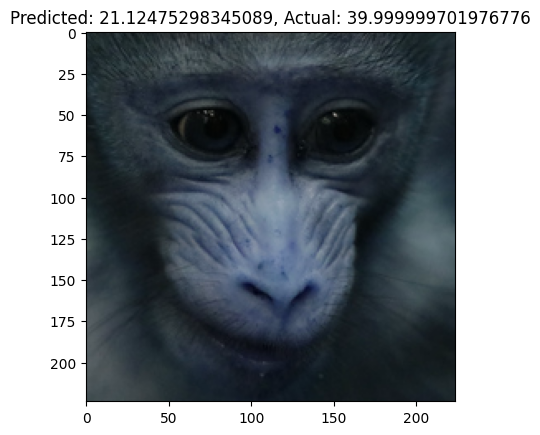

Predicted Values: 8.62322405911982
Actual Values: 10.999999782070518
Prediction Error:  -2.376775722950697



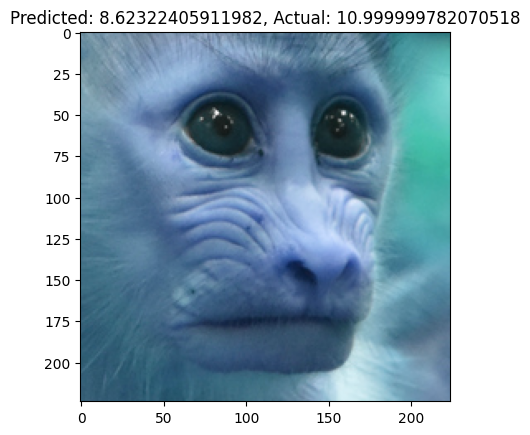

Predicted Values: 124.02220293879509
Actual Values: 111.00000515580177
Prediction Error:  13.022197782993317



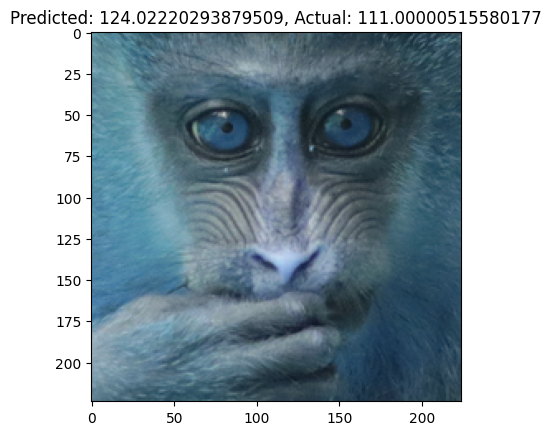

Predicted Values: 53.848625645041466
Actual Values: 53.00000123679638
Prediction Error:  0.8486244082450867



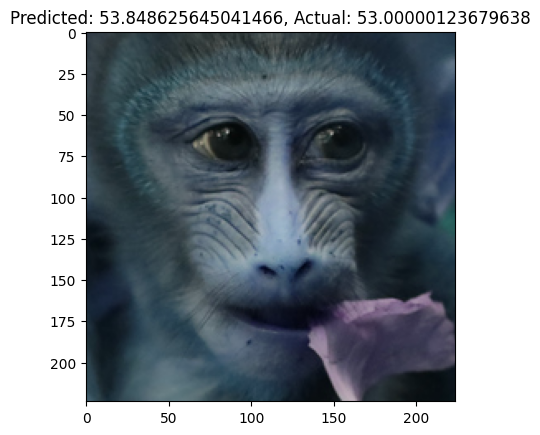

Predicted Values: 157.88734674453735
Actual Values: 182.99998939037323
Prediction Error:  -25.112642645835876



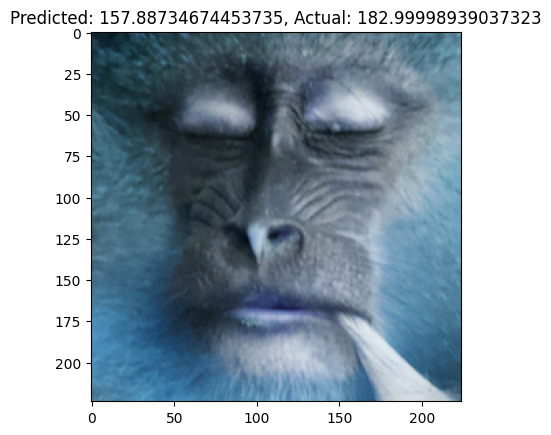

Predicted Values: 48.83514530956745
Actual Values: 8.000000212341547
Prediction Error:  40.835145097225904



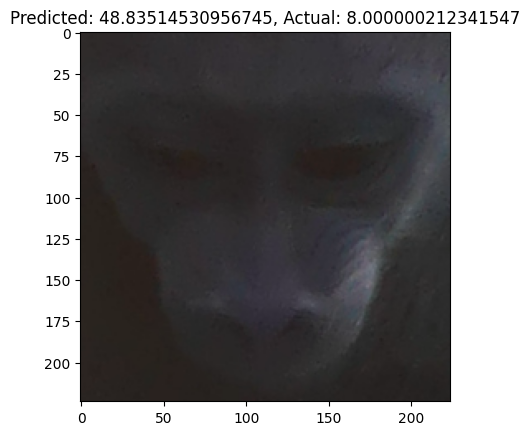

Predicted Values: 126.81535139679909
Actual Values: 98.99999871850014
Prediction Error:  27.81535267829895



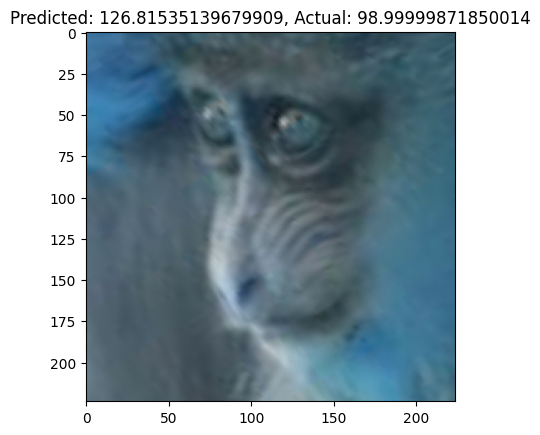

Absolute age error (in days):  0.17065981133856764  std:  35.68447285140673


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

# model = load(model, "vgg_face", exp_name="exp1_regression")

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * 365
    actual_values = targets.squeeze().cpu().numpy() * 365
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", predicted_values)
    print("Actual Values:", actual_values)
    print("Prediction Error: ", predicted_values - actual_values)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

age_errors = np.array(age_errors)
print("Absolute age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

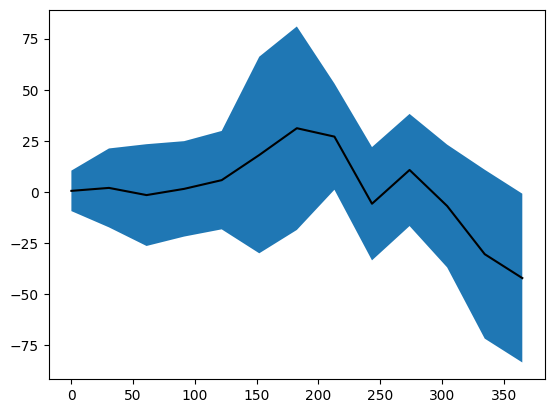

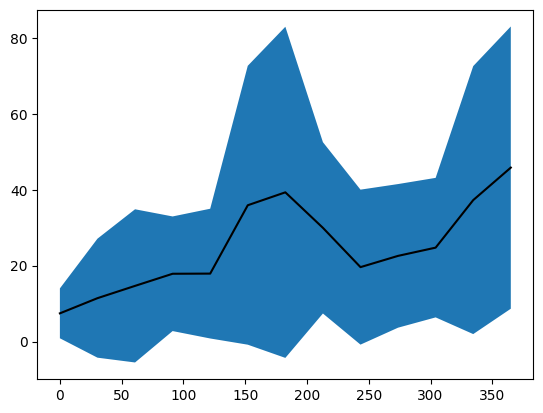

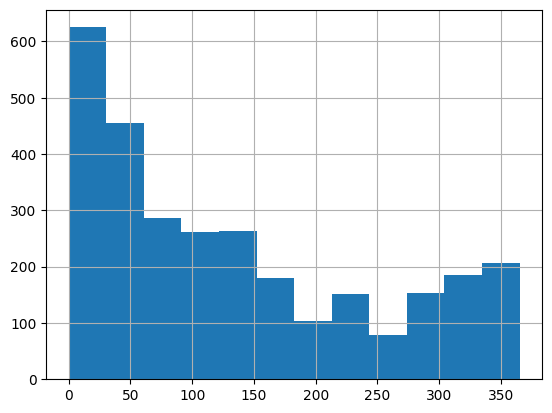

In [4]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 12

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)

# Distribution of image according to the age
hist = data["age"].hist(bins=n_bins)

In [ ]:
from mandrill.utils import save
name="exp1_regression_exp_loss"
save(model, "vgg_face", exp_name=name)
print("saved")